## Virtual Gates

The central part of QVM are virtual gates, that allow the virtualization of a binary gate by sampling single-qubit gates. Any `VirtualBinaryGate` is a special `Gate` that additionally exposes the two methods `configure()` and `knit()`. `configure()` is responsible for providing all circuit-samples that need to be executed and `knit()` calculates the result of all executions of the samples.
QVM provides the three virtual gates [`VirtualCX`](./qvm/virtual_gate/virtual_cx.py), [`VirtualCZ`](./qvm/virtual_gate/virtual_cz.py) and [`VirtualRZZ`](./qvm//virtual_gate//virtual_rzz.py). 

Since a virtual gate is a subclass of `Gate`, they can be appended nomally to a `QuantumCircuit`, e.g.:


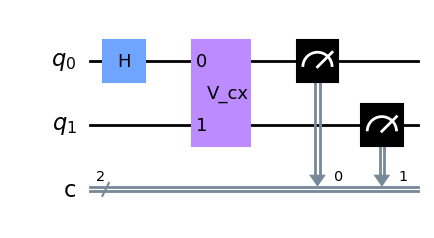

In [21]:
import logging
from qvm.virtual_gate import VirtualCX
from qiskit import QuantumCircuit
from IPython.display import display

# disable any logging
logging.basicConfig(level=logging.CRITICAL)

circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.append(VirtualCX(), (0, 1), ())
circuit.measure(0, 0)
circuit.measure(1, 1)
circuit.draw('mpl')

Virtual gates can also be inserted into an existing circuit by calling `virtualize_connection()`, which inserts virtual gates instead of real gates between two qubits, e.g.:

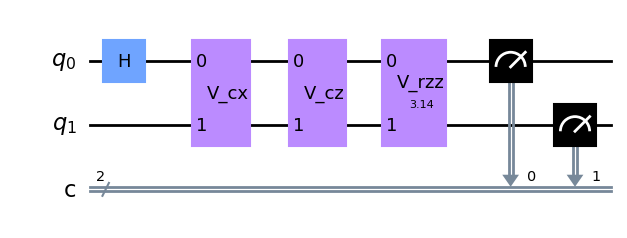

In [22]:
from qvm import virtualize_connection

circuit = QuantumCircuit(2, 2)
circuit.h(0)
circuit.cx(0, 1)
circuit.cz(0, 1)
circuit.rzz(3.14, 0, 1)
circuit.measure(0, 0)
circuit.measure(1, 1)

virtualize_connection(circuit, circuit.qubits[0], circuit.qubits[1])
circuit.draw('mpl')

## Fragmented Circuit

Virtual gates allow us now to dissect a circuit int multiple fragmens. For this, we first need to decompose the virtual gates into each a pair of vgate-endpoints. Then we can convert the circuit into a `FragmentedCircuit` object. A `FragmentedCircuit` consists of multiple `Fragment`s (subclass of `QuantumCircuit`), that have the same classical registers. 

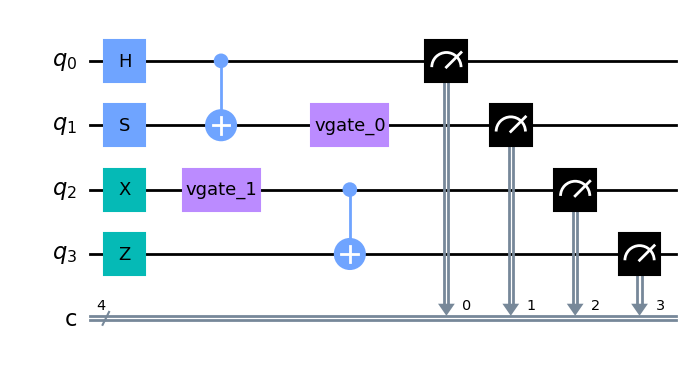

In [23]:
from qvm.virtual_gate.virtual_gate import VirtualBinaryGate

circuit = QuantumCircuit(4, 4)
circuit.h(0)
circuit.s(1)
circuit.x(2)
circuit.z(3)
circuit.cx(0, 1)
circuit.cz(1, 2)
circuit.cx(2, 3)
circuit.measure(0, 0)
circuit.measure(1, 1)
circuit.measure(2, 2)
circuit.measure(3, 3)
# make a copy for later
circuit_cp = circuit.copy()

virtualize_connection(circuit, circuit.qubits[1], circuit.qubits[2])
circuit = circuit.decompose([VirtualBinaryGate,])
circuit.draw('mpl')

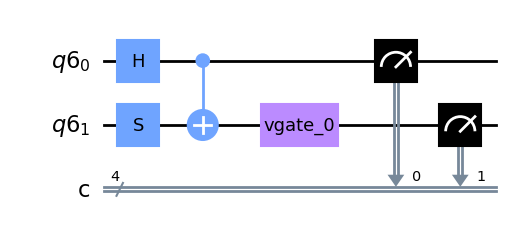

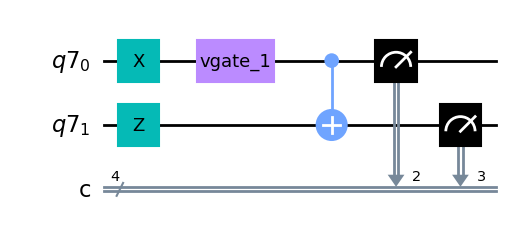

In [24]:
from qvm import FragmentedCircuit

frag_circ = FragmentedCircuit(circuit)
for frag in frag_circ.fragments:
    display(frag.draw('mpl'))
    

## Execution

To execute a fragmented circuit, you can transpile the fragments respectively for specific backends, and set the backend attribute of the fragments accordingly.


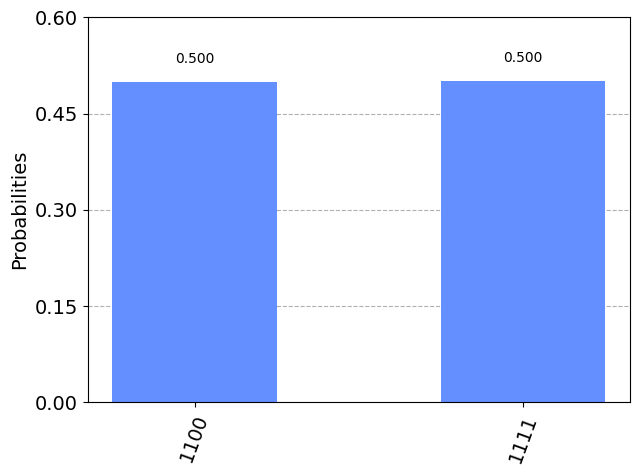

In [27]:
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator, StatevectorSimulator
from qvm import execute_fragmented_circuit, Fragment

fragments = frag_circ.fragments

# IMPORTANT: don't change the vgate enpoints
# make sure that the endpoint of the vgate will get ignored on transpilation
basis_gates = ["vgate_end"] + ["u1", "u2", "u3", "cx"]

fragments[0] = Fragment.from_circuit(
    transpile(fragments[0], backend=AerSimulator(), basis_gates=basis_gates)
)
fragments[0].backend = AerSimulator()

fragments[1] = Fragment.from_circuit(
    transpile(fragments[1], backend=StatevectorSimulator(), basis_gates=basis_gates)
)
fragments[1].backend = StatevectorSimulator()

counts = execute_fragmented_circuit(frag_circ, shots=10000)
plot_histogram(counts)


In [28]:
# compare to "real" execution
from qvm.bench.fidelity import fidelity

fid = fidelity(circuit_cp, counts)
print(f"hellinger fidelity is {fid}")

hellinger fidelity is 0.9999990840007243


## Transpiler

The virtualization of gates and the following fragmentation can be done automatically using transpilers that try to optimially virtualize gates, dissect the circuit, and map the fragments to backends.
The QVM transpiler infrastructure is divided into three main transpiler types: `DecompositionTranspiler`, `DeviceMappingTranspiler` and `LayoutTranspiler`.

### Decomposition Transpiler

A `DecompositionTranspiler` aims to virtualize binary gates and fragment a circuit optimally. An example for a `DecompositionTranspiler` is the `Bisection`, which partitions a circuit into 2 equally sized fragments:

### DeviceMappingTranspiler

### Layout Transpiler

A `LayoutTranspiler` enables optimal logical-to-physical qubit mapping by vitualizing certain qubit connections